<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/Colab_Mission_Coincidences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

# Mission Coincidences
This notebook finds concident acquisition regions for three missions: Landsat-8, Sentinel-2 and Sentinel-1. Each of these missions has a different orbit and revisit rates, so coincident pairs (two missions at the same location and day) are not that common and coincident triplets (all 3 missions at the same location and day) are extremely rare. These coincidences are quite valuable for comparing datasets for calibration and validation purposes or for providing viable locations for a combined product analysis.

## Load Data Cube Configuration and Import Utilities

In [ ]:
# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Mission_Coincidences')

# Import Utilities
from IPython.display import display_html
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

## Create new functions to display data output and find coincidences

* `display_side_by_side`: A method [found here](https://stackoverflow.com/a/44923103) for displaying Pandas DataFrames next to each other in one output.
* `find_coincidences`: A helper method to return the various intersection of dates for the three products.
* `s1_rgb`: Generates an RGB image from a Sentinel-1 dataset.

In [4]:
def display_side_by_side(*args, index=True):
    html_str=''
    for df in args:
        if index:
            html_str+=df.to_html()
        else:
            html_str+=df.to_html(index=False)
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
def find_coincidence(ls_index, s1_index, s2_index):        
    return {'LS⋂S2': ls_index.intersection(s2_index).values,
            'LS⋂S1': ls_index.intersection(s1_index).values,
            'S2⋂S1': s2_index.intersection(s1_index).values,
            'LS⋂S2⋂S1': ls_index.intersection(s2_index).intersection(s1_index).values}

def s1_rgb(ds, rrange=(-25, 0), grange=(-30,-5), brange=(0,15)):
    r = ds.vv
    g = ds.vh
    b = r - g
    # Clip the data to remove extreme outliers
    r = np.clip(r, rrange[0], rrange[1])
    g = np.clip(g, grange[0], grange[1])
    b = np.clip(b, brange[0], brange[1])
    # Normalize the data to improve colors
    r = (r-r.min())/(r.max()-r.min())
    g = (g-g.min())/(g.max()-g.min())
    b = (b-b.min())/(b.max()-b.min())
    # Name the bands
    r.name = 'vv'
    g.name = 'vh'
    b.name = 'vv/vh'
    return xr.merge((r,g,b))

### Analysis parameters

* `latitude`: The latitude extents for the analysis area.
* `longitude`: The longitude extents for the analysis area.
* `time`: The time window for the analysis (Year-Month)

In [5]:
# MODIFY HERE

# Select the center of an analysis region (lat_long) 
# Adjust the surrounding box size (box_size) around the center (in degrees)
# Remove the comment tags (#) below to change the sample location

# Barekese Dam, Ghana, Africa
lat_long = (6.846, -1.709)
box_size_deg = 0.05

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

time = ('2019-1', '2019-12')

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load partial datasets
Load only the dates, coordinate, and scene classification values if available for determining cloud coverage.

In [7]:
# Define the product details to load in the next code block
platforms = {'LANDSAT_8': dict(product=f'ls8_google',latitude=latitude,longitude=longitude),
             'SENTINEL-1': dict(product=f's1_google',group_by='solar_day'),
             'SENTINEL-2': dict(product=f's2_google',group_by='solar_day')}

In [8]:
# Load Landsat 8 data including times and pixel_qa (cloud cover)
ls_dataset = dc.load(measurements=['pixel_qa'], time=time, **platforms['LANDSAT_8'])

# Load Sentinel-2 data including times and scl (cloud cover)
s2_dataset = dc.load(like=ls_dataset, measurements=['scl'], time=time, **platforms['SENTINEL-2'])

# Load Basic Sentinel-1 data with only time slice details
s1_dataset = dc.load(like=ls_dataset, measurements=[], time=time, **platforms['SENTINEL-1'])

## Cloud Masking
Create cloud masks for the optical data (Landsat-8 and Sentinel-2)

In [9]:
ls_clean_mask = landsat_qa_clean_mask(ls_dataset, platform='LANDSAT_8')

s2_clean_mask = (s2_dataset.scl != 0) & (s2_dataset.scl != 1) & \
                (s2_dataset.scl != 3) & (s2_dataset.scl != 8) & \
                (s2_dataset.scl != 9) & (s2_dataset.scl != 10)

/content/utils/data_cube_utilities/clean_mask.py:278: UserWarning: Please specify a value for `collection`. Assuming data is collection 1.
  warnings.warn('Please specify a value for `collection`. Assuming data is collection 1.')
/content/utils/data_cube_utilities/clean_mask.py:283: UserWarning: Please specify a value for `level`. Assuming data is level 2.
  warnings.warn('Please specify a value for `level`. Assuming data is level 2.')


## Display a table of scenes
Filter optical data by cloud cover

In [10]:
# MODIFY HERE

# Percent of clean pixels in the optical images.
# The default is 80% which will yield mostly clear scenes

percent_clean = 80

In [11]:
# Display the dates and cloud information for the available scenes

ls_df = pd.DataFrame(list(zip(ls_dataset.time.values.astype('datetime64[D]'),
                              [round(mask.mean().item()*100, 2) for mask in ls_clean_mask],
                              [mask.sum().item() for mask in ls_clean_mask])),
                     columns=['Landsat 8 Date', 'clean_pixel_percent', 'clean_pixel_count'])\
                     .query(f'clean_pixel_percent >= {percent_clean}')
s2_df = pd.DataFrame(list(zip(s2_dataset.time.values.astype('datetime64[D]'),
                              [round(mask.mean().item()*100, 2) for mask in s2_clean_mask],
                              [mask.sum().item() for mask in s2_clean_mask])),
                     columns=['Sentinel-2 Date', 'clean_pixel_percent', 'clean_pixel_count'])\
                     .query(f'clean_pixel_percent >= {percent_clean}')
s1_df = pd.DataFrame(list(s1_dataset.time.values.astype('datetime64[D]')),
                     columns=['Sentinel-1 Date'])

display_side_by_side(ls_df, s2_df, s1_df)

,Landsat 8 Date,clean_pixel_percent,clean_pixel_count
1,2019-01-22,99.61,34647
4,2019-03-11,100.00,34782
5,2019-03-27,97.93,34062
6,2019-04-12,96.11,33430
10,2019-12-08,98.44,34240
11,2019-12-24,100.00,34782
,Sentinel-2 Date,clean_pixel_percent,clean_pixel_count
0,2019-01-02,100.00,34782
2,2019-01-12,99.16,34490
4,2019-01-22,100.00,34782


## Coincidences
Find the coincidence dates for the datasets using the filtered data from the previous section.

In [12]:
ls_index = pd.Index(ls_df['Landsat 8 Date'].values)
s2_index = pd.Index(s2_df['Sentinel-2 Date'].values)
s1_index = pd.Index(s1_df['Sentinel-1 Date'].values)

In [13]:
# List the double and triple coincidences
args = [pd.DataFrame(val, columns=[key]) for key, val in find_coincidence(ls_index, s1_index, s2_index).items()]
display_side_by_side(*args, index=False)

LS⋂S2
2019-01-22
2019-04-12
2019-12-08
LS⋂S1
2019-01-22
2019-03-11
2019-12-24
S2⋂S1
2019-01-22
2019-03-23


## Plot a single time selection to view the scene details
Select and plot a time from the coincidence results listed above.

In [14]:
# MODIFY HERE

# Select a time from the table above.
time_selection = '2019-01-22'

In [15]:
# Define the plotting bands for each image on the specified date

s1 = s2 = ls = None
if ls_dataset.time.dt.floor('D').isin(np.datetime64(time_selection)).sum():
    ls = dc.load(measurements=['red', 'green', 'blue'],
                 time=time_selection, **platforms['LANDSAT_8'])
if s2_dataset.time.dt.floor('D').isin(np.datetime64(time_selection)).sum():
    s2 = dc.load(like=ls_dataset, measurements=['red', 'green', 'blue'],
                 time=time_selection, **platforms['SENTINEL-2'])
if s1_dataset.time.dt.floor('D').isin(np.datetime64(time_selection)).sum():
    s1 = dc.load(like=ls_dataset, measurements=['vv', 'vh'],
                 time=time_selection, **platforms['SENTINEL-1'])

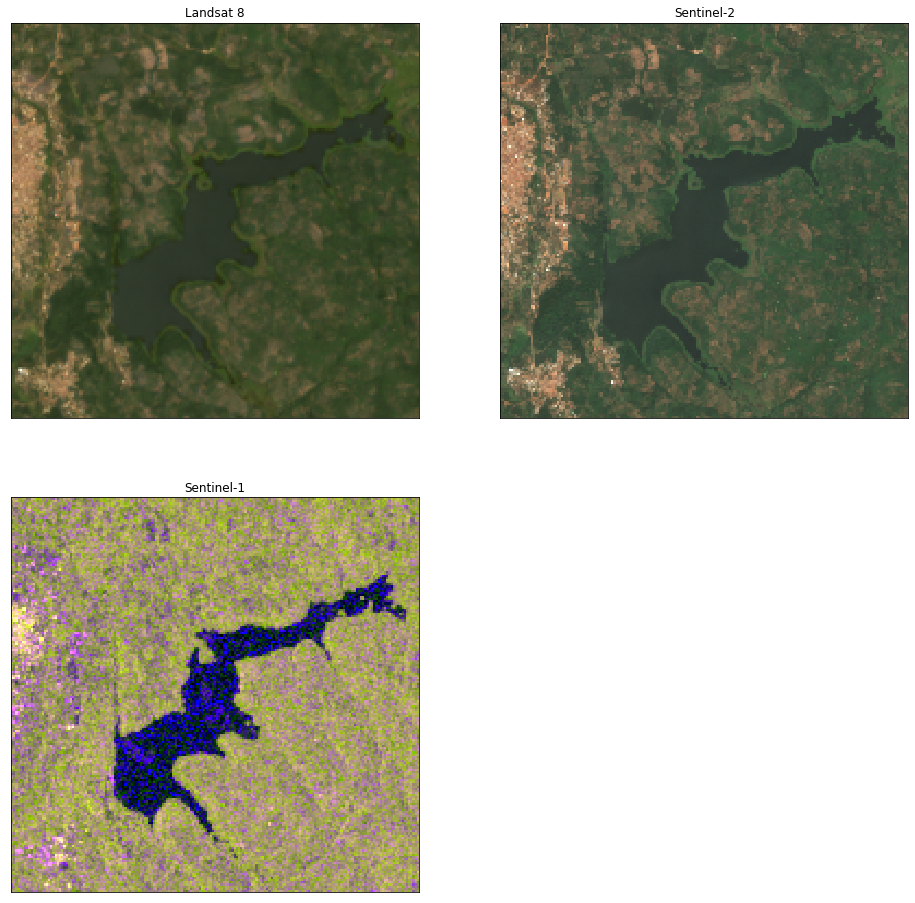

In [16]:
# Plot sample images for the specified date. 
# Based on the selected date, there will be either 2 or 3 images shown below. 

fig, ax = plt.subplots(2, 2, figsize=(ls_dataset.longitude.size/ls_dataset.latitude.size*16,16))

if ls:
    ls.isel(time=0).to_array().plot.imshow(ax=ax[0][0], vmin=0, vmax=2000)
    ax[0][0].set_title('Landsat 8')
    ax[0][0].xaxis.set_visible(False), ax[0][0].yaxis.set_visible(False)
if s2:
    s2.isel(time=0).to_array().plot.imshow(ax=ax[0][1], vmin=0, vmax=2000)
    ax[0][1].set_title('Sentinel-2')
    ax[0][1].xaxis.set_visible(False), ax[0][1].yaxis.set_visible(False)
if s1:
    s1_rgb(s1.isel(time=0)).to_array().plot.imshow(ax=ax[1][0])
    ax[1][0].set_title('Sentinel-1')
    ax[1][0].xaxis.set_visible(False), ax[1][0].yaxis.set_visible(False)
ax[1][1].axis('off');